# Midterm Sweep — Auxiliary Value (RGB)

Pull WANDB sweep `y8whrxxa`, cache the payload locally, and compare multi-gamma auxiliary value variants against the original TD-MPC2 pixel baselines.

In [1]:
from pathlib import Path
import sys

NOTEBOOK_DIR = Path().resolve()
REPO_ROOT = NOTEBOOK_DIR.parent.parent
if not (REPO_ROOT / "analysis" / "tools").exists():
    raise RuntimeError("Unable to locate analysis/tools package from notebook directory")
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [2]:
import pandas as pd

from IPython.display import Image
from analysis.tools import aggregations, baselines, naming, plotting, selection, wandb_io, paths
from analysis.tools.paths import ensure_dir

In [3]:
NOTEBOOK_STEM = "midterm_aux_value_rgb"
SWEEP_ROOT = Path("../../sweep_list/midterm_sweep/1aux_value/rgb").resolve()
SWEEP_ID = SWEEP_ROOT.joinpath("id.txt").read_text().strip()
WANDB_PROJECT = SWEEP_ROOT.joinpath("project.txt").read_text().strip()
WANDB_ENTITY = "thomasevers9"
HISTORY_KEYS = [
    "eval/episode_reward",
    "eval/step",
    "train/step",
    "global_step",
    "total_env_steps",
    "step",
    "_step",
]
STEP_KEYS = ["eval/step", "train/step", "global_step", "total_env_steps", "step", "_step"]
METRIC_KEY = "eval/episode_reward"
STEP_TARGET = 500_000
COMPARISON_STEP = 200_000
RESULTS_DIR = paths.notebook_results_dir(NOTEBOOK_STEM)
RESULTS_DIR

PosixPath('/home/thoma/projects/auxiliary_targets/tdmpc2/analysis/results/midterm_aux_value_rgb')

In [4]:
runs_payload, manifest, data_source = wandb_io.fetch_sweep_runs(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    sweep_id=SWEEP_ID,
    history_keys=HISTORY_KEYS,
    use_cache=True,
    force_refresh=False,
)
print(f"Loaded {manifest['run_count']} runs from {data_source}")

Loaded 90 runs from cache


In [5]:
CONFIG_TO_COLUMNS = {"task": "task", "seed": "seed", "multi_gamma_gammas": "multi_gamma_gammas"}

runs_df = aggregations.runs_history_to_frame(
    runs_payload,
    metric_key=METRIC_KEY,
    step_keys=STEP_KEYS,
    config_to_columns=CONFIG_TO_COLUMNS,
)
runs_df["task_baseline"] = runs_df["task"].map(naming.wandb_task_to_baseline)
runs_df["variant_label"] = runs_df["multi_gamma_gammas"].apply(
    lambda gammas: ", ".join(str(x) for x in gammas) if isinstance(gammas, tuple) else str(gammas)
)
runs_df.head()

,task,seed,multi_gamma_gammas,run_id,step,eval/episode_reward,task_baseline,variant_label
0,finger_turn_hard,304,"(0.8,)",0og59m15,0,0.000000,finger-turn-hard,0.8
1,finger_turn_hard,304,"(0.8,)",0og59m15,25000,194.100006,finger-turn-hard,0.8
2,finger_turn_hard,304,"(0.8,)",0og59m15,50000,158.500000,finger-turn-hard,0.8
3,finger_turn_hard,304,"(0.8,)",0og59m15,75000,493.899994,finger-turn-hard,0.8
4,finger_turn_hard,304,"(0.8,)",0og59m15,100000,293.899994,finger-turn-hard,0.8


In [6]:
print("Available history keys:", runs_payload[0]["history"]["keys"] if runs_payload else "<no runs>")

Available history keys: ['eval/episode_reward', 'eval/step', 'train/step', 'global_step', 'total_env_steps', 'step', '_step']


In [7]:
tasks = sorted(runs_df["task_baseline"].unique())
baseline_df = baselines.load_many(tasks)
baseline_df.head()

,step,reward,seed,task
0,0,5.4,2,acrobot-swingup
1,100000,8.0,2,acrobot-swingup
2,200000,45.4,2,acrobot-swingup
3,300000,48.2,2,acrobot-swingup
4,400000,76.9,2,acrobot-swingup


In [8]:
summary_tables = []

for task in tasks:
    task_df = runs_df[runs_df["task_baseline"] == task]
    if task_df.empty:
        raise ValueError(f"No sweep rows found for task {task}")
    if not (task_df["step"] == STEP_TARGET).any():
        raise ValueError(f"Sweep data missing step {STEP_TARGET} for task {task}")

    baseline_task_df = baseline_df[baseline_df["task"] == task]
    if baseline_task_df.empty:
        raise ValueError(f"Baseline CSV missing task {task}")
    if not (baseline_task_df["step"] == STEP_TARGET).any():
        raise ValueError(f"Baseline data missing step {STEP_TARGET} for task {task}")

    task_dir = ensure_dir(RESULTS_DIR / task)
    sample_fig = plotting.sample_efficiency_figure(
        frame=task_df,
        metric_key=METRIC_KEY,
        variant_column="multi_gamma_gammas",
        task_name=task,
        baseline_frame=baseline_task_df,
        baseline_label="tdmpc2-pixels",
    )
    plotting.write_png(
        sample_fig,
        output_path=task_dir / "sample_efficiency.png",
    )

    agg = aggregations.aggregate_at_step(
        task_df,
        step_value=STEP_TARGET,
        metric_key=METRIC_KEY,
        group_cols=["multi_gamma_gammas"],
    )

    baseline_at_step = baseline_task_df[baseline_task_df["step"] == STEP_TARGET]
    bar_fig = plotting.bar_chart_at_step(
        aggregated_frame=agg,
        metric_column="mean_reward",
        variant_column="multi_gamma_gammas",
        baseline_rows=baseline_at_step,
        baseline_label="tdmpc2-pixels",
        task_name=task,
    )
    plotting.write_png(
        bar_fig,
        output_path=task_dir / "reward_500k.png",
    )

    agg["task"] = task
    agg["baseline_reward"] = baseline_at_step["reward"].mean()
    summary_tables.append(agg)

summary_df = pd.concat(summary_tables, ignore_index=True)
summary_csv_path = RESULTS_DIR / "reward_500k_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)
summary_df

,multi_gamma_gammas,mean_reward,std_reward,num_runs,task,baseline_reward
0,"(0.8,)",208.871292,57.913434,3,acrobot-swingup,52.566667
1,"(0.8, 0.95)",239.959452,84.430606,3,acrobot-swingup,52.566667
2,"(0.95,)",179.534668,40.430891,3,acrobot-swingup,52.566667
3,"(0.8,)",599.306681,74.810026,3,cheetah-run,454.933333
4,"(0.8, 0.95)",597.963928,9.072433,3,cheetah-run,454.933333
5,"(0.95,)",606.486287,36.327965,3,cheetah-run,454.933333
6,"(0.8,)",983.633341,6.997408,3,finger-spin,982.933333
7,"(0.8, 0.95)",982.433329,5.921432,3,finger-spin,982.933333
8,"(0.95,)",978.200012,9.704134,3,finger-spin,982.933333
9,"(0.8,)",674.933350,107.804747,3,finger-turn-easy,580.866667


In [9]:
comparison_runs_df = runs_df.copy()
comparison_runs_df["task"] = comparison_runs_df["task_baseline"]
comparison_runs_df = comparison_runs_df[comparison_runs_df["task"].isin(tasks)]
if comparison_runs_df.empty:
    raise ValueError("No sweep rows remain after restricting to tasks with baseline coverage")

missing_tasks = [
    task
    for task in tasks
    if not ((comparison_runs_df["task"] == task) & (comparison_runs_df["step"] == COMPARISON_STEP)).any()
 ]
if missing_tasks:
    raise ValueError(
        "Sweep data missing step "
        + str(COMPARISON_STEP)
        + " for tasks: "
        + ", ".join(missing_tasks)
    )

comparison_best = selection.best_configuration_at_step(
    comparison_runs_df,
    metric_key=METRIC_KEY,
    step_value=COMPARISON_STEP,
    hyperparam_columns=["multi_gamma_gammas"],
)

config_summary = comparison_best.config_summary.sort_values("mean_reward", ascending=False)
best_config_row = config_summary.iloc[0]
best_config_mean_reward = float(best_config_row["mean_reward"])

best_gammas = comparison_best.config["multi_gamma_gammas"]
if isinstance(best_gammas, (tuple, list)):
    best_config_label = ", ".join(str(value) for value in best_gammas)
else:
    best_config_label = str(best_gammas)

best_config_description = f"multi_gamma_gammas={best_config_label}"
config_summary.head(10)

,multi_gamma_gammas,mean_reward,std_across_tasks,task_count
2,"(0.95,)",602.196308,289.468424,10
0,"(0.8,)",575.117718,266.653850,10
1,"(0.8, 0.95)",574.434691,275.265320,10


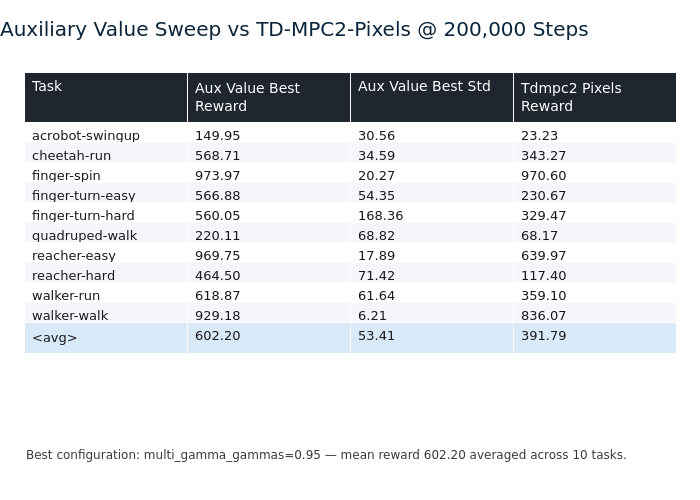

In [10]:
baseline_comparison_df = baseline_df[baseline_df["task"].isin(tasks)]
baseline_step_subset = baseline_comparison_df[baseline_comparison_df["step"] == COMPARISON_STEP]
missing_baseline_tasks = sorted(
    set(tasks) - set(baseline_step_subset["task"].unique())
)
if missing_baseline_tasks:
    raise ValueError(
        "Baseline data missing step "
        + str(COMPARISON_STEP)
        + " for tasks: "
        + ", ".join(missing_baseline_tasks)
    )

comparison_baselines = {"tdmpc2-pixels": baseline_comparison_df}
comparison_df = selection.comparison_table(
    model_task_summary=comparison_best.task_summary,
    baselines=comparison_baselines,
    step_value=COMPARISON_STEP,
    model_label="aux-value-best",
)

comparison_csv_path = RESULTS_DIR / f"comparison_table_{COMPARISON_STEP}.csv"
comparison_df.to_csv(comparison_csv_path, index=False)

footer_text = (
    f"Best configuration: {best_config_description} — mean reward "
    f"{best_config_mean_reward:.2f} averaged across {comparison_best.task_summary.shape[0]} tasks."
 )

comparison_title = f"Auxiliary Value Sweep vs TD-MPC2-Pixels @ {COMPARISON_STEP:,} Steps"
comparison_fig = plotting.comparison_table_figure(
    comparison_df,
    title=comparison_title,
    footer_text=footer_text,
)
comparison_png_path = RESULTS_DIR / f"comparison_table_{COMPARISON_STEP}.png"
plotting.write_png(comparison_fig, output_path=comparison_png_path)
Image(filename=str(comparison_png_path))